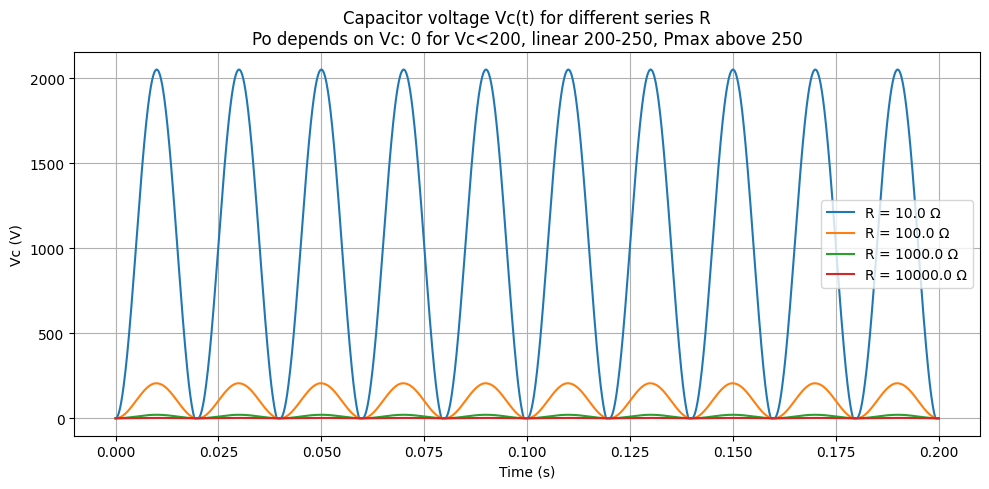

     R (Ω)    min Vc (V)   max Vc (V)  mean Vc (V)  std Vc (V)
0     10.0  0.000000e+00  2051.205848  1016.276013  731.163159
1    100.0  0.000000e+00   206.004547   102.467875   73.105817
2   1000.0  0.000000e+00    20.690143    10.345071    7.315801
3  10000.0  3.490211e-15     2.069014     1.034507    0.731580


,R (Ω),min Vc (V),max Vc (V),mean Vc (V),std Vc (V)
0,10.0,0.000000e+00,2051.205848,1016.276013,731.163159
1,100.0,0.000000e+00,206.004547,102.467875,73.105817
2,1000.0,0.000000e+00,20.690143,10.345071,7.315801
3,10000.0,3.490211e-15,2.069014,1.034507,0.731580


In [2]:
# Modified simulation implementing Vc-dependent Po and Vc(0)=0
# C * dVc/dt = (Vpeak/R) * sin(omega*t) - Po(Vc)/Vc
# Po(Vc) = 0 for Vc < 200
# Po(Vc) = Pmax * (Vc - 200) / 50  for 200 <= Vc <= 250 (linear from 0 to Pmax)
# Po(Vc) = Pmax for Vc > 250
# When Po(Vc)==0 we set i_load = 0 to avoid 0/0; otherwise use Po/Vc with a small floor on Vc.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi, sin

# Parameters (you can change these)
Vpeak = 325.0        # peak AC voltage (V)
f = 50.0             # frequency (Hz)
omega = 2*pi*f
Pmax = 200.0         # maximum constant power when Vc > 250 V
C = 100e-6           # capacitance (F)
R_list = [10.0, 100.0, 1000.0, 10000.0]  # series R values to compare (ohm)

t0 = 0.0
t_end = 0.2          # simulate 0.2 s (10 cycles at 50 Hz)
dt = 1e-5            # time step (s)
N = int((t_end - t0) / dt) + 1
time = np.linspace(t0, t_end, N)

# Initial capacitor voltage
Vc0 = 0.0  # as requested

def Po_of_Vc(Vc):
    if Vc < 200.0:
        return 0.0
    elif Vc <= 250.0:
        return Pmax * (Vc - 200.0) / 50.0
    else:
        return Pmax

def ode_rhs(t, Vc, R):
    # source current through R
    i_in = (Vpeak / R) * sin(omega * t)
    Po_local = Po_of_Vc(Vc)
    # if Po_local is zero, load current is zero (avoid 0/0)
    if Po_local == 0.0:
        i_load = 0.0
    else:
        # protect division by tiny Vc
        Vc_safe = max(Vc, 1e-6)
        i_load = Po_local / Vc_safe
    dVcdt = (i_in - i_load) / C
    return dVcdt

def integrate_rk4(R):
    Vc = np.empty_like(time)
    Vc[0] = Vc0
    for k in range(len(time)-1):
        t = time[k]
        h = dt
        k1 = ode_rhs(t, Vc[k], R)
        k2 = ode_rhs(t + 0.5*h, Vc[k] + 0.5*h*k1, R)
        k3 = ode_rhs(t + 0.5*h, Vc[k] + 0.5*h*k2, R)
        k4 = ode_rhs(t + h, Vc[k] + h*k3, R)
        Vc_next = Vc[k] + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        # enforce a non-negative floor (physical: can't go below 0)
        Vc[k+1] = max(Vc_next, 0.0)
    return Vc

# Run simulations
results = {}
for R in R_list:
    Vc = integrate_rk4(R)
    results[R] = Vc

# Plot Vc(t) for each R (single figure)
plt.figure(figsize=(10,5))
for R in R_list:
    plt.plot(time, results[R], label=f"R = {R} Ω")
plt.xlabel("Time (s)")
plt.ylabel("Vc (V)")
plt.title("Capacitor voltage Vc(t) for different series R\nPo depends on Vc: 0 for Vc<200, linear 200-250, Pmax above 250")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics over the last 0.05 s
t_cut = t_end - 0.05
idx_cut = np.searchsorted(time, t_cut)
summary_rows = []
for R in R_list:
    V = results[R][idx_cut:]
    summary_rows.append({
        "R (Ω)": R,
        "min Vc (V)": float(np.min(V)),
        "max Vc (V)": float(np.max(V)),
        "mean Vc (V)": float(np.mean(V)),
        "std Vc (V)": float(np.std(V))
    })
summary_df = pd.DataFrame(summary_rows)

# Display table to user if helper is available, else print
try:
    import caas_jupyter_tools as cjt
    cjt.display_dataframe_to_user("Vc summary (last 0.05 s) with Vc-dependent Po", summary_df)
except Exception:
    print(summary_df)

summary_df



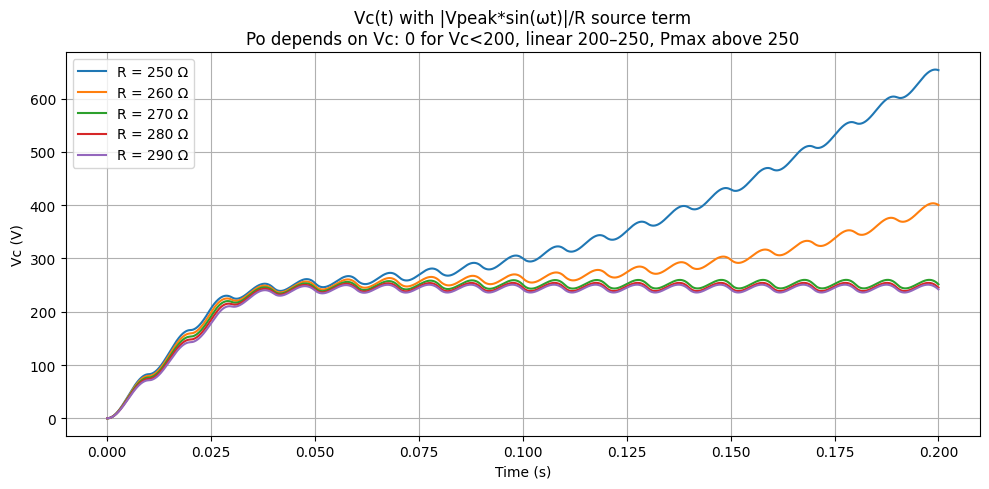

   R (Ω)  min Vc (V)  max Vc (V)  mean Vc (V)  std Vc (V)
0    250  426.745498  654.441270   534.598117   66.222252
1    260  291.628905  403.468218   341.445593   31.279445
2    270  243.711541  259.786590   251.797662    5.718153
3    280  238.787367  254.115377   246.613035    5.468413
4    290  236.052341  250.775460   243.627396    5.262128


,R (Ω),min Vc (V),max Vc (V),mean Vc (V),std Vc (V)
0,250,426.745498,654.441270,534.598117,66.222252
1,260,291.628905,403.468218,341.445593,31.279445
2,270,243.711541,259.786590,251.797662,5.718153
3,280,238.787367,254.115377,246.613035,5.468413
4,290,236.052341,250.775460,243.627396,5.262128


In [9]:
# Modified simulation: use absolute value of the source waveform in the ODE
# C * dVc/dt = |Vpeak * sin(omega*t)|/R - Po(Vc)/Vc
# Po(Vc) same piecewise definition as before.
# Initial Vc(0)=0. Run for multiple R values and show plots + summary.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi, sin

# Parameters (changeable)
Vpeak = 325.0        # peak AC voltage (V)
f = 50.0             # frequency (Hz)
omega = 2*pi*f
Pmax = 200.0         # maximum constant power when Vc > 250 V
C = 100e-6           # capacitance (F)
# R_list = [250, 300, 500.0, 1000.0]  # series R values to compare (ohm)
R_list = list(range(250, 300, 10))  # 100 to 1000 ohm in steps of 100
t0 = 0.0
t_end = 0.2          # simulate 0.2 s (10 cycles at 50 Hz)
dt = 1e-5            # time step (s)
N = int((t_end - t0) / dt) + 1
time = np.linspace(t0, t_end, N)

# Initial capacitor voltage
Vc0 = 0.0  # initial condition as requested

def Po_of_Vc(Vc):
    if Vc < 200.0:
        return 0.0
    elif Vc <= 250.0:
        return Pmax * (Vc - 200.0) / 50.0
    else:
        return Pmax

def ode_rhs(t, Vc, R):
    # source current through R using absolute value of the sinusoid
    i_in = (abs(Vpeak * sin(omega * t))) / R
    Po_local = Po_of_Vc(Vc)
    # if Po_local is zero, load current is zero (avoid 0/0)
    if Po_local == 0.0:
        i_load = 0.0
    else:
        # protect division by tiny Vc
        Vc_safe = max(Vc, 1e-6)
        i_load = Po_local / Vc_safe
    dVcdt = (i_in - i_load) / C
    return dVcdt

def integrate_rk4(R):
    Vc = np.empty_like(time)
    Vc[0] = Vc0
    for k in range(len(time)-1):
        t = time[k]
        h = dt
        k1 = ode_rhs(t, Vc[k], R)
        k2 = ode_rhs(t + 0.5*h, Vc[k] + 0.5*h*k1, R)
        k3 = ode_rhs(t + 0.5*h, Vc[k] + 0.5*h*k2, R)
        k4 = ode_rhs(t + h, Vc[k] + h*k3, R)
        Vc_next = Vc[k] + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        # enforce a non-negative floor (physical: can't go below 0)
        Vc[k+1] = max(Vc_next, 0.0)
    return Vc

# Run simulations
results = {}
for R in R_list:
    Vc = integrate_rk4(R)
    results[R] = Vc

# Plot Vc(t) for each R (single figure)
plt.figure(figsize=(10,5))
for R in R_list:
    plt.plot(time, results[R], label=f"R = {R} Ω")
plt.xlabel("Time (s)")
plt.ylabel("Vc (V)")
plt.title("Vc(t) with |Vpeak*sin(ωt)|/R source term\nPo depends on Vc: 0 for Vc<200, linear 200–250, Pmax above 250")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics over the last 0.05 s
t_cut = t_end - 0.05
idx_cut = np.searchsorted(time, t_cut)
summary_rows = []
for R in R_list:
    V = results[R][idx_cut:]
    summary_rows.append({
        "R (Ω)": R,
        "min Vc (V)": float(np.min(V)),
        "max Vc (V)": float(np.max(V)),
        "mean Vc (V)": float(np.mean(V)),
        "std Vc (V)": float(np.std(V))
    })
summary_df = pd.DataFrame(summary_rows)

# Display DataFrame to user
try:
    import caas_jupyter_tools as cjt
    cjt.display_dataframe_to_user("Vc summary (last 0.05 s) with absolute source", summary_df)
except Exception:
    print(summary_df)

summary_df

